# AE 483: Final Project
### Search & Rescue with Variable Mass
#### Charlie Ray, Dennis McCann, Vivek Kodali, Michael Biela

# 1. Setup the Notebook

Import modules

In [2]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d

Define a function to load data from hardware. 

#### This function was created by Professor Bretl ####

In [3]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        if 'ae483log.o_z_des' not in resampled_data.keys():
            raise Exception('"ae483log.o_z_des" must be logged')
        i = np.argwhere(resampled_data['ae483log.o_z_des'] > 0).flatten()
        if len(i) == 0:
            raise Exception('o_z_des was never positive')
        if len(i) < 2:
            raise Exception('o_z_des was only positive for one time step')
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

In [4]:
def export_power_distribution(Pinv,
                              limiter='self.limitUint16',
                              decimals=1,
                              suffix='',
                              line_ending=''):
    """
    Pinv is a 4 x 4 matrix that maps inputs (tau_x, tau_y, tau_z, f_z)
        to motor power commands (m_1, m_2, m_3, m_4)
    limiter is the name of the function to apply that ensures each
        motor power command is valid (i.e., an integer within bounds),
        for example "limitUint16" when exporting to C
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    i_name = ['tau_x', 'tau_y', 'tau_z', 'f_z']
    m_name = ['m_1', 'm_2', 'm_3', 'm_4']
    for row in range(len(m_name)):
        input_string = ''
        for col in range(len(i_name)):
            k = Pinv[row, col]
            if not np.isclose(k, 0.):
                if (k > 0) and input_string:
                    input_string += ' +'
                n = i_name[col]
                input_string += f' {k:.{decimals}f}{suffix} * {n}'
        print(f'{m_name[row]} = {limiter}({input_string} ){line_ending}')

In [5]:
def export_controller(K, s, i, s_with_des, i_eq,
                      decimals=8,
                      suffix='',
                      line_ending=''):
    """
    K is a gain matrix, of size m x n
    s is a list of states as symbolic variables, of length n
    i is a list of inputs as symbolic variables, of length m
    s_with_des is a list of states that have desired values, as
        symbolic variables - if there are no such states, then
        this should be an empty list []
    i_eq is a list of equilibrium values of inputs, of length m
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    s_name = [scur.name for scur in s]
    i_name = [icur.name for icur in i]
    for row in range(len(i_name)):
        input_string = ''
        for col in range(len(s_name)):
            k = K[row, col]
            if not np.isclose(k, 0.):
                if (k < 0) and input_string:
                    input_string += ' +'
                if s[col] in s_with_des:
                    n = f'({s_name[col]} - {s_name[col]}_des)'
                else:
                    n = s_name[col]
                input_string += f' {-k:.{decimals}f}{suffix} * {n}'
        if not np.isclose(i_eq[row], 0.):
            if (i_eq[row] > 0) and input_string:
                input_string += ' +'
            input_string += f' {i_eq[row]:.{decimals}f}{suffix}'
        print(f'{i_name[row]} ={input_string}{line_ending}')

In [6]:
def resample(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

# 2. Derive Models

## 2.1. Symbolic Variables

Define States:

In [7]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

Define Inputs:

In [8]:
# gyroscope measurements - components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# z-axis accelerometer measurement - specific force (meters / second^2)
a_z = sym.symbols('a_z')

Define Outputs:

In [9]:
n_x, n_y, r = sym.symbols('n_x, n_y, r')

# New ouputs from sensors
x0, y0, z0, d0 = sym.symbols('x0, y0, z0, d0')
x1, y1, z1, d1 = sym.symbols('x1, y1, z1, d1')
x2, y2, z2, d2 = sym.symbols('x2, y2, z2, d2')
x3, y3, z3, d3 = sym.symbols('x3, y3, z3, d3')
x4, y4, z4, d4 = sym.symbols('x4, y4, z4, d4')
x5, y5, z5, d5 = sym.symbols('x5, y5, z5, d5')
x6, y6, z6, d6 = sym.symbols('x6, y6, z6, d6')
x7, y7, z7, d7 = sym.symbols('x7, y7, z7, d7')

Define Parameters:

In [10]:
g, k_flow = sym.symbols('g, k_flow')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

m_sym, J_x_sym, J_y_sym, J_z_sym, g_sym = sym.symbols('m, J_x, J_y, J_z, g')

Create linear and angular velocity vectors (in coordinates of the body frame)

In [11]:
v_01in1 = sym.Matrix([[v_x], [v_y], [v_z]])
w_01in1 = sym.Matrix([[w_x], [w_y], [w_z]])

Create a moment of inertia matrix (in coordinates of the body frame)

In [12]:
J_in1 = sym.diag(J_x_sym, J_y_sym, J_z_sym)
s_with_des = [o_x, o_y, o_z]

## 2.2. Define Kinematics of Orientation

### 2.2.1. Rotation Matrix in terms of Yaw, Pitch, and Roll Angles

Define individual rotation matrices

In [13]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone

In [14]:
R_1in0 = Rz * Ry * Rx

### 2.2.2. Map from Angular Velocities to Angular Rates

This can be done using the following equation:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{0, 1}^{1}$$

In [15]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([[0], [0], [1]]),
                              (Rx).T * sym.Matrix([[0], [1], [0]]),
                                       sym.Matrix([[1], [0], [0]]))
        
N = sym.simplify(Ninv.inv())

## 2.3. Derive Equations of Motion

Ratio of net thrust to mass, in terms of z-axis accelerometer measurement

In [16]:
f_z_over_m = a_z + (w_01in1.cross(v_01in1))[2]

Ratio of forces to mass

In [17]:
f_in1_over_m = R_1in0.T * sym.Matrix([[0], [0], [-g_sym]]) + sym.Matrix([[0], [0], [f_z_over_m]])

f_in1 = R_1in0.T * sym.Matrix([[0], [0], [-m_sym * g_sym]]) + sym.Matrix([[0], [0], [f_z]])

Torques

In [18]:
tau_in1 = sym.Matrix([[tau_x], [tau_y], [tau_z]])

Equations of Motion:

In [19]:
f_sym = sym.Matrix.vstack(
    R_1in0 * v_01in1,
    N * w_01in1,
    (1 / m_sym) * (f_in1 - w_01in1.cross(m_sym * v_01in1)),
    J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1)))

These Equations of Motion have the following form:

$$\dot{s} = f(s, i, p)$$

where

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} \tau_x \\ \tau_y \\ \tau_z \\ f_z \end{bmatrix},
\qquad\qquad
p = \begin{bmatrix} m \\ J_x \\ J_y \\ J_z \\ g \end{bmatrix}.
$$

In [20]:
f_sym

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)],
[                                                                                                               w_y*cos(phi) - w_z*sin(phi)],
[                                                                                   w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                (g*m*sin(theta) + m*v_y*w_z - m*v_z*w_y)/m

## 2.4. Derive Measurement Equations

Up until now, everything we have done has been exactly the same as was done in class (in fact, all of the code has been copied from the lab 7 jupyter notebook). Here, however, is where we begin to deviate.

Below is an array of the measurement equations we used in lab, concatenated with the new measurement equations that result from the loco positioning system. 

In [21]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

In [22]:
h = sym.Matrix([
    k_flow * (v_x - o_z * w_y) / o_z,        # <-- x flow (n_x)
    k_flow * (v_y + o_z * w_x) / o_z,        # <-- y flow (n_y)
    o_z / (sym.cos(phi) * sym.cos(theta)),   # <-- z range (r)
])

# New Measurement equations
h2 = sym.Matrix([
    ((o_x - x0)**2 + (o_y - y0)**2 + (o_z - z0)**2)**(1/2),   # < -- distance from anchor 0 (d0)
    ((o_x - x1)**2 + (o_y - y1)**2 + (o_z - z1)**2)**(1/2),   # < -- distance from anchor 1 (d1)
    ((o_x - x2)**2 + (o_y - y2)**2 + (o_z - z2)**2)**(1/2),   # < -- distance from anchor 2 (d2)
    ((o_x - x3)**2 + (o_y - y3)**2 + (o_z - z3)**2)**(1/2),   # < -- distance from anchor 3 (d3)
    ((o_x - x4)**2 + (o_y - y4)**2 + (o_z - z4)**2)**(1/2),   # < -- distance from anchor 4 (d4)
    ((o_x - x5)**2 + (o_y - y5)**2 + (o_z - z5)**2)**(1/2),   # < -- distance from anchor 5 (d5)
    ((o_x - x6)**2 + (o_y - y6)**2 + (o_z - z6)**2)**(1/2),   # < -- distance from anchor 6 (d6)
    ((o_x - x7)**2 + (o_y - y7)**2 + (o_z - z7)**2)**(1/2)    # < -- distance from anchor 7 (d7)
])

These measurement equations have the form

$$o = h(s, i, p)$$

where

$$
o = \begin{bmatrix} n_x \\ n_y \\ r \end{bmatrix}
\qquad\qquad
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \\ k_\text{flow} \end{bmatrix}.
$$

In [23]:
h2

Matrix([
[((o_x - x0)**2 + (o_y - y0)**2 + (o_z - z0)**2)**0.5],
[((o_x - x1)**2 + (o_y - y1)**2 + (o_z - z1)**2)**0.5],
[((o_x - x2)**2 + (o_y - y2)**2 + (o_z - z2)**2)**0.5],
[((o_x - x3)**2 + (o_y - y3)**2 + (o_z - z3)**2)**0.5],
[((o_x - x4)**2 + (o_y - y4)**2 + (o_z - z4)**2)**0.5],
[((o_x - x5)**2 + (o_y - y5)**2 + (o_z - z5)**2)**0.5],
[((o_x - x6)**2 + (o_y - y6)**2 + (o_z - z6)**2)**0.5],
[((o_x - x7)**2 + (o_y - y7)**2 + (o_z - z7)**2)**0.5]])

In [24]:
o_x_eq, o_y_eq, o_z_eq = sym.symbols('o_x_eq, o_y_eq, o_z_eq')

In [25]:
# Old state, input, output and parameters
# s = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z]
# i = [w_x, w_y, w_z, a_z]
# o = [n_x, n_y, r]
# p = [g_sym, k_flow]

# # New state, input, output, and paramters
s = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
i = [tau_x, tau_y, tau_z, f_z]
o = [d0, d1, d2, d3, d4, d5, d6, d7]
p = [m_sym, J_x_sym, J_y_sym, J_z_sym, g_sym]

In [26]:
# # Old state and input equilibrium lists
# s_eq = [0, 0, o_z_eq, 0, 0, 0, 0, 0, 0]
# i_eq = [0, 0, 0, g_sym]

# # New state and input equilibrium lists
# s_eq = [o_x_eq, o_y_eq, o_z_eq, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# i_eq = [0, 0, 0, g_sym]

Define constants

In [27]:
# Mass
m = 0.04275    # <-- FIXME

# Principle moments of inertia
J_x = 0.00002079685  # <-- FIXME
J_y = 0.00002122075  # <-- FIXME
J_z = 0.000030112233  # <-- FIXME

# Acceleration of gravity
g = 9.81

In [28]:
f = sym.lambdify(s + i + p, f_sym)

# f_sym.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))


Parameters

In [29]:
p_eq = [m, J_x, J_y, J_z, g]

equilibrum arrays for parameters

In [30]:
s_eq = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.] # <-- FIXME
i_eq = [0., 0., 0., m*g]                    # <-- FIXME

In [31]:
i_eq

[0.0, 0.0, 0.0, 0.41937750000000007]

In [32]:
f_lam = sym.lambdify(s + i + p, f_sym)

print(f_lam(*s_eq, *i_eq, *p_eq))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


# FIND A AND B AND C AND D

In [33]:
# Find A, B, C, D OLD
A_old = f_sym.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
B_old = f_sym.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
C_old = h.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
D_old = h.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

# New A, B, C, and D 
A_sym = f_sym.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
B_sym = f_sym.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
C = h2.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
D = h2.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

In [34]:
A_num = sym.lambdify(s + i + p, A_sym)
A = A_num(*s_eq, *i_eq, *p_eq)
A

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  9.81,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -9.81,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  

In [35]:
B_num = sym.lambdify(s + i + p, B_sym)
B = B_num(*s_eq, *i_eq, *p_eq)


In [36]:
C

Matrix([
[-1.0*x0*(x0**2 + y0**2 + z0**2)**(-0.5), -1.0*y0*(x0**2 + y0**2 + z0**2)**(-0.5), -1.0*z0*(x0**2 + y0**2 + z0**2)**(-0.5), 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-1.0*x1*(x1**2 + y1**2 + z1**2)**(-0.5), -1.0*y1*(x1**2 + y1**2 + z1**2)**(-0.5), -1.0*z1*(x1**2 + y1**2 + z1**2)**(-0.5), 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-1.0*x2*(x2**2 + y2**2 + z2**2)**(-0.5), -1.0*y2*(x2**2 + y2**2 + z2**2)**(-0.5), -1.0*z2*(x2**2 + y2**2 + z2**2)**(-0.5), 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-1.0*x3*(x3**2 + y3**2 + z3**2)**(-0.5), -1.0*y3*(x3**2 + y3**2 + z3**2)**(-0.5), -1.0*z3*(x3**2 + y3**2 + z3**2)**(-0.5), 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-1.0*x4*(x4**2 + y4**2 + z4**2)**(-0.5), -1.0*y4*(x4**2 + y4**2 + z4**2)**(-0.5), -1.0*z4*(x4**2 + y4**2 + z4**2)**(-0.5), 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-1.0*x5*(x5**2 + y5**2 + z5**2)**(-0.5), -1.0*y5*(x5**2 + y5**2 + z5**2)**(-0.5), -1.0*z5*(x5**2 + y5**2 + z5**2)**(-0.5), 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-1.0*x6*(x6**2 + y6**2 + z6**2)**(-0.5), -1.0*y6*(x6**2 + y6**2 + z6**2)**(-0.

In [37]:
D

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

# 4. Design method of power distribution

## Finding k_F unsing linear regression

In [93]:
data5 = resample('some_data_force2.json',
                t_min_offset=2.,
                t_max_offset=8.)
m_1 = data5['ae483log.m_1']
m_2 = data5['ae483log.m_2']
m_3 = data5['ae483log.m_3']
m_4 = data5['ae483log.m_4']

a_z_ = data5['ae483log.a_z']



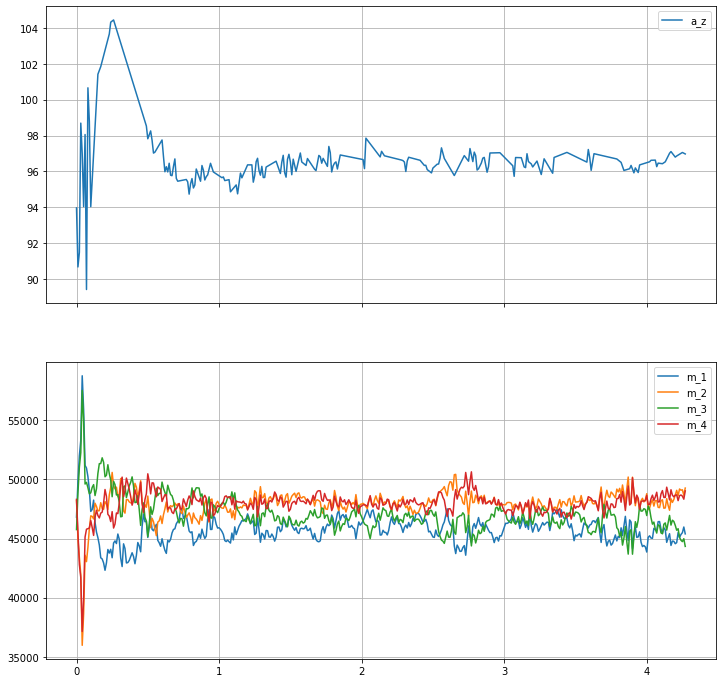

In [94]:
t = data5['time']
# a_x = g * data5['ae483log.a_x']
# a_y = g * data5['ae483log.a_y']
a_z = g * data5['ae483log.a_z']

fig, (ax_a, ax_m) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
# ax_a.plot(t, a_x, label='a_x')
# ax_a.plot(t, a_y, label='a_y')
ax_a.plot(t, a_z, label='a_z')
ax_a.legend()
ax_a.grid()
ax_m.plot(t, m_1, label='m_1')
ax_m.plot(t, m_2, label='m_2')
ax_m.plot(t, m_3, label='m_3')
ax_m.plot(t, m_4, label='m_4')
ax_m.legend()
ax_m.grid()

In [95]:
x = m_1 + m_2 + m_3 + m_4 # <-- FIXME (REPLACE WITH CODE TO DEFINE THE "X" IN LINEAR REGRESSION)
y = m*a_z # <-- FIXME (REPLACE WITH CODE TO DEFINE THE "Y" IN LINEAR REGRESSION)
c_est = np.sum(y * x) / np.sum(x**2) # <-- FIXME (REPLACE WITH CODE TO COMPUTE THE ESTIMATE OF "C" IN LINEAR REGRESSION)
k_F = c_est 
k_F


2.1945156431045235e-05

## Finding k_M using linear regression

In [96]:
data6 = resample('some_data_moment2.json',
                t_min_offset=3.,
                t_max_offset=6.)
t = data6['time']
m_1 = data6['ae483log.m_1']
m_2 = data6['ae483log.m_2']
m_3 = data6['ae483log.m_3']
m_4 = data6['ae483log.m_4']
w_x = np.deg2rad(data6['ae483log.w_x'])
w_y = np.deg2rad(data6['ae483log.w_y'])
w_z = np.deg2rad(data6['ae483log.w_z'])

a_z_ = data5['ae483log.a_z']

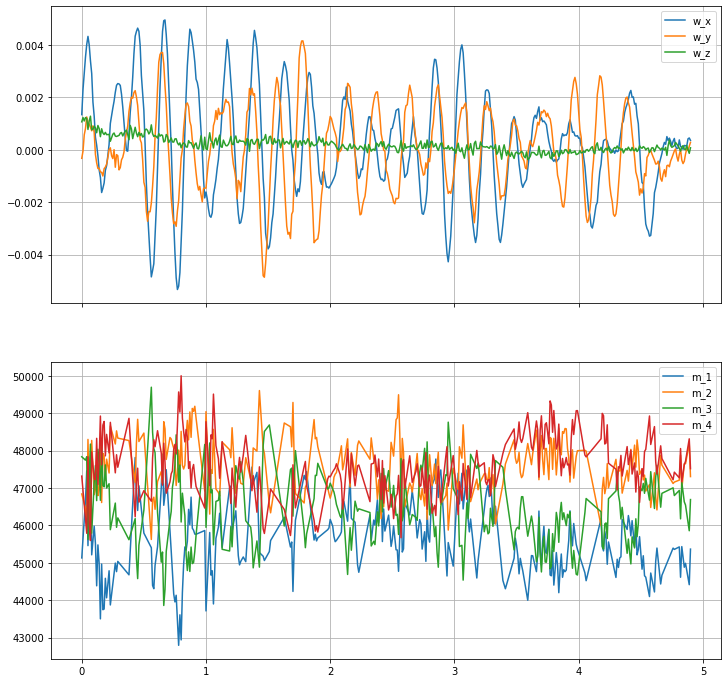

In [97]:
fig, (ax_w, ax_m) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax_w.plot(t, w_x, label='w_x')
ax_w.plot(t, w_y, label='w_y')
ax_w.plot(t, w_z, label='w_z')
ax_w.legend()
ax_w.grid()
ax_m.plot(t, m_1, label='m_1')
ax_m.plot(t, m_2, label='m_2')
ax_m.plot(t, m_3, label='m_3')
ax_m.plot(t, m_4, label='m_4')
ax_m.legend()
ax_m.grid()

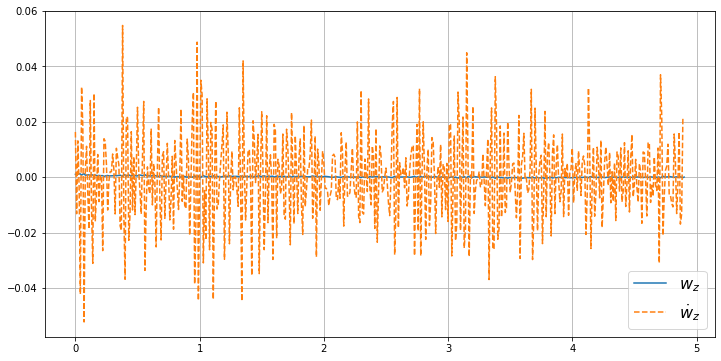

In [98]:
dt = t[1] - t[0]
w_z_dot = (w_z[1:] - w_z[:-1]) / dt
plt.figure(figsize=(12, 6))
plt.plot(t, w_z, label='$w_z$')
plt.plot(t[:-1], w_z_dot, '--', label='$\dot{w}_z$')
plt.grid()
plt.legend(fontsize=16)


In [99]:
x = (-m_1 + m_2 - m_3 + m_4)
y = J_z*w_z_dot 
c_est = np.sum(y * x[:-1]) / np.sum(x[:-1]**2) 
k_M = c_est 
k_M

1.9090723196106693e-11

## Final k_F and k_M Values

In [100]:
# k_F_old = 2.08e-06 # <-- FIXME
# k_M_old = 4.47e-09 # <-- FIXME
l = 0.035  # <-- FIXME
print('k_F=', k_F)
print('k_M=', k_M)


k_F= 2.1945156431045235e-05
k_M= 1.9090723196106693e-11


In [101]:
P = np.array([[ -l * k_F, -l * k_F,  l * k_F,  l * k_F  ],
              [ -l * k_F, l * k_F,   l * k_F,  -l * k_F ],
              [ -k_M,     k_M,       -k_M,     k_M      ],
              [ k_F,      k_F,       k_F,      k_F      ]])

Pinv = linalg.inv(P)

In [102]:
export_power_distribution(Pinv)

m_1 = self.limitUint16( -325486.7 * tau_x -325486.7 * tau_y -13095365609.4 * tau_z + 11392.0 * f_z )
m_2 = self.limitUint16( -325486.7 * tau_x + 325486.7 * tau_y + 13095365609.4 * tau_z + 11392.0 * f_z )
m_3 = self.limitUint16( 325486.7 * tau_x + 325486.7 * tau_y -13095365609.4 * tau_z + 11392.0 * f_z )
m_4 = self.limitUint16( 325486.7 * tau_x -325486.7 * tau_y + 13095365609.4 * tau_z + 11392.0 * f_z )


In [103]:
export_power_distribution(
    Pinv,
    limiter='limitUint16',
    suffix='f',
    line_ending=';',
)

m_1 = limitUint16( -325486.7f * tau_x -325486.7f * tau_y -13095365609.4f * tau_z + 11392.0f * f_z );
m_2 = limitUint16( -325486.7f * tau_x + 325486.7f * tau_y + 13095365609.4f * tau_z + 11392.0f * f_z );
m_3 = limitUint16( 325486.7f * tau_x + 325486.7f * tau_y -13095365609.4f * tau_z + 11392.0f * f_z );
m_4 = limitUint16( 325486.7f * tau_x -325486.7f * tau_y + 13095365609.4f * tau_z + 11392.0f * f_z );


In [104]:
## BRYSONS RULE

# part 1
m_max = Pinv @ np.array([[0], [0], [0], [m*g]])

# part 2
m_max_diff = 65535 - m_max[0][0]

# part 3
m_max_diff_idiv = m_max_diff/4

# part 4
tx_max = l*k_F*(4*m_max_diff_idiv)
ty_max = l*k_F*(4*m_max_diff_idiv)
tz_max = k_M*(4*m_max_diff_idiv)
fz_max = k_F*(4*m_max_diff_idiv)

r1 = (1/tx_max)**2
r2 = (1/ty_max)**2
r3 = (1/tz_max)**2
r4 = (1/fz_max)**2

R_bryson = np.diag([r1, r2, r3, r4])

In [105]:
# Q = np.diag([
#     1.,
#     1.,
#     1.,
#     1.,
#     1.,
#     1.,
#     1.,
#     1.,
#     1.,
#     1.,
#     1.,
#     1.,
# ])

# # R = 1e1 * R_bryson
# R = 1e6 * np.diag([
#     1.,
#     1.,
#     1.,
#     1.,
# ])

Q = np.diag([
    100,
    100,
    100,
    0.02533,
    0.40528,
    0.40528,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

R = np.diag([
    426808.,
    426808.,
    426808.,
    426808.,
])


In [106]:
K = lqr(A, B, Q, R)

In [107]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

K = [[ 0.000 -0.015  0.000  0.000  0.000  0.015  0.000 -0.007 -0.000  0.002  0.000 -0.000]
     [ 0.015 -0.000 -0.000 -0.000  0.015  0.000  0.007 -0.000 -0.000  0.000  0.002  0.000]
     [ 0.000 -0.000  0.000  0.000  0.000  0.000  0.000 -0.000  0.000 -0.000  0.000  0.002]
     [ 0.000  0.000  0.015  0.000 -0.000 -0.000 -0.000 -0.000  0.036 -0.000 -0.000  0.000]]


In [108]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
)

tau_x = 0.01530678 * (o_y - o_y_des) -0.01531366 * phi + 0.00708036 * v_y -0.00172625 * w_x
tau_y = -0.01530678 * (o_x - o_x_des) -0.01533204 * theta -0.00708441 * v_x -0.00173023 * w_y
tau_z = -0.00024361 * psi -0.00153546 * w_z
f_z = -0.01530678 * (o_z - o_z_des) -0.03620873 * v_z + 0.41937750


In [109]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
    suffix='f',      # character to print after each number (indicates a "float")
    line_ending=';'  # character to print after each line
)

tau_x = 0.01530678f * (o_y - o_y_des) -0.01531366f * phi + 0.00708036f * v_y -0.00172625f * w_x;
tau_y = -0.01530678f * (o_x - o_x_des) -0.01533204f * theta -0.00708441f * v_x -0.00173023f * w_y;
tau_z = -0.00024361f * psi -0.00153546f * w_z;
f_z = -0.01530678f * (o_z - o_z_des) -0.03620873f * v_z + 0.41937750f;
